In [1]:
import arviz as az
import pandas as pd
import numpy as np
import sqlite3
import os
import pprint
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from helper import *
import bambi as bmb
import pymc as pm
from multiprocessing import cpu_count

pp = pprint.PrettyPrinter(indent=2)

%matplotlib inline

# Data Collection

In [2]:
current_folder = os.path.abspath('')
db_file = os.path.join(current_folder, r"data/data.db")
db = sqlite3.connect(db_file)

In [3]:
query = r""" 
    SELECT events, launch_angle, launch_speed, estimated_ba_using_speedangle, hc_x, hc_y, hit_distance_sc, stand, bb_type
    FROM statcast
    WHERE type = 'X' AND
        events NOT LIKE 'sac_%'
"""
raw_data = pd.read_sql_query(query, db)

In [4]:
data = raw_data.copy()
hit_events = {
    'single':1,
    'double':2,
    'triple':3,
    'home_run':4
}

data = data.dropna(axis='index')
data['is_hit'] = np.where(data['events'].isin(hit_events.keys()), 1, 0)
data['bases_earned'] = data.apply(get_bases_earned, axis='columns')
data['spray_angle'] = data.apply(get_spray_angle, axis='columns')

In [5]:
rng = np.random.RandomState(seed=6420)
X_train, X_test, y_train, y_test = train_test_split(data.drop("is_hit", axis="columns"), data["is_hit"], test_size = 0.3, random_state=rng)

# Baseline

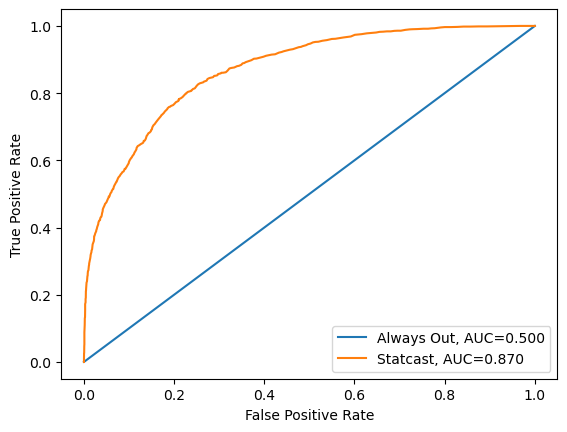

In [7]:
always_out = np.zeros_like(y_test)
plt.figure(0).clf()

fpr_ao, tpr_ao, _ = roc_curve(y_test, always_out)
auc_ao = roc_auc_score(y_test, always_out)
fpr_statcast, tpr_statcast, _ = roc_curve(y_test, X_test['estimated_ba_using_speedangle'])
auc_statcast = roc_auc_score(y_test, X_test['estimated_ba_using_speedangle'])

plt.plot(fpr_ao, tpr_ao, label=f"Always Out, AUC={auc_ao:0.3f}")
plt.plot(fpr_statcast, tpr_statcast, label=f"Statcast, AUC={auc_statcast:0.3f}")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

            Accuracy  Sensitivity  Specificity  F1 Score
Always Out  0.670866     0.000000     1.000000  0.000000
Statcast    0.800388     0.606968     0.895282  0.666846


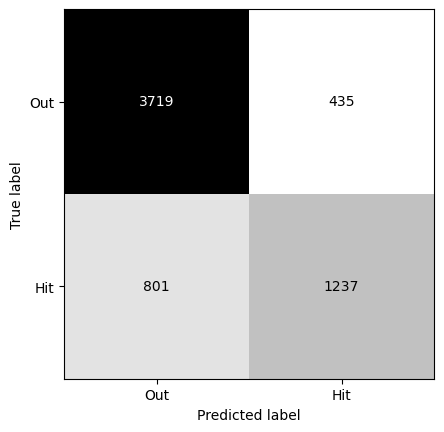

In [8]:
cm_ao = confusion_matrix(y_test, always_out)
cm_statcast = confusion_matrix(y_test, np.round(X_test['estimated_ba_using_speedangle']))

eda_scores = pd.DataFrame([cm_scores(y_test, always_out), 
                           cm_scores(y_test, np.round(X_test['estimated_ba_using_speedangle']))],
                           index=["Always Out", "Statcast"])
print(eda_scores)

ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=np.round(X_test['estimated_ba_using_speedangle']),
                                        display_labels=["Out", "Hit"], colorbar=False, cmap="binary");

# Standard Logisitic Regression

{ 'Accuracy': 0.7525839793281653,
  'F1 Score': 0.5976890756302521,
  'Sensitivity': 0.5583905789990187,
  'Specificity': 0.8478574867597496}


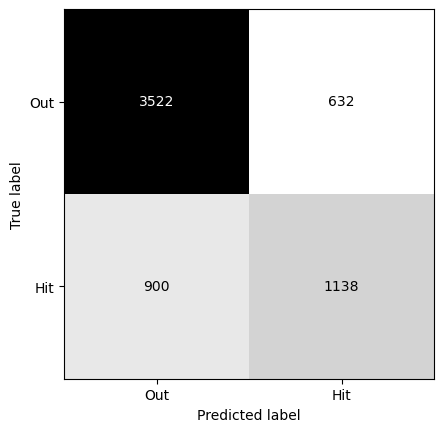

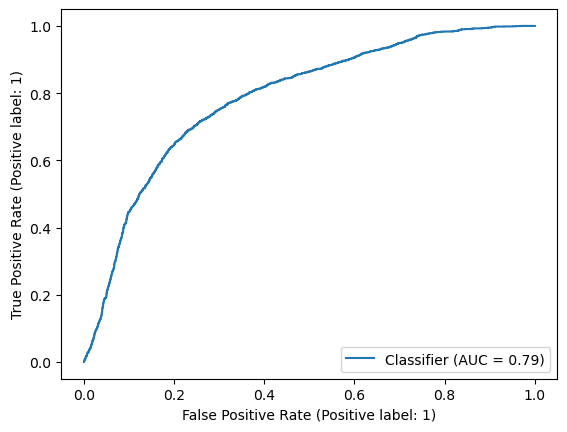

In [7]:
speed_angle_train = X_train[["launch_speed", "launch_angle", "hit_distance_sc"]].copy()
speed_angle_train["interaction"] = speed_angle_train.loc[:,"launch_angle"] * speed_angle_train.loc[:,"hit_distance_sc"]
speed_angle_test = X_test[["launch_speed", "launch_angle", "hit_distance_sc"]].copy()
speed_angle_test["interaction"] = speed_angle_test.loc[:,"launch_angle"] * speed_angle_test.loc[:,"hit_distance_sc"]
logit_model = LogisticRegression().fit(speed_angle_train, y_train)
logit_pred = logit_model.predict_proba(speed_angle_test)
logit_pred = [p[1] for p in logit_pred]

ConfusionMatrixDisplay.from_predictions(y_test, np.round(logit_pred), display_labels=["Out", "Hit"], colorbar=False, cmap="binary");
RocCurveDisplay.from_predictions(y_test, logit_pred);
pp.pprint(cm_scores(y_test, np.round(logit_pred)))

# Bayesian Model

In [7]:
bayes_data = pd.concat([y_train, X_train], axis="columns")

In [8]:
priors = {
    "launch_speed": bmb.Prior("Normal", mu=0, sigma=10),
    "launch_angle": bmb.Prior("Normal", mu=0, sigma=10)
}
bayes_model = bmb.Model("is_hit ~ launch_angle + launch_speed", data=bayes_data, priors=priors, family="bernoulli")
model_filepath = os.path.join(current_folder, r"models/bayes_speed_angle.model")
if os.path.exists(model_filepath):
    bayes_results = az.from_netcdf(model_filepath)
else:
    bayes_results = bayes_model.fit(chains=4, cores=cpu_count(), inference_method="nuts_numpyro")
    az.to_netcdf(bayes_results, model_filepath)

In [9]:
bayes_model.predict(bayes_results, data=X_test, kind="pps")

{ 'Accuracy': 0.6844315245478036,
  'F1 Score': 0.17552742616033754,
  'Sensitivity': 0.10206084396467124,
  'Specificity': 0.9701492537313433}


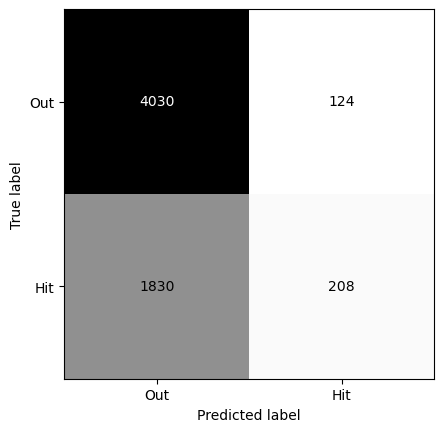

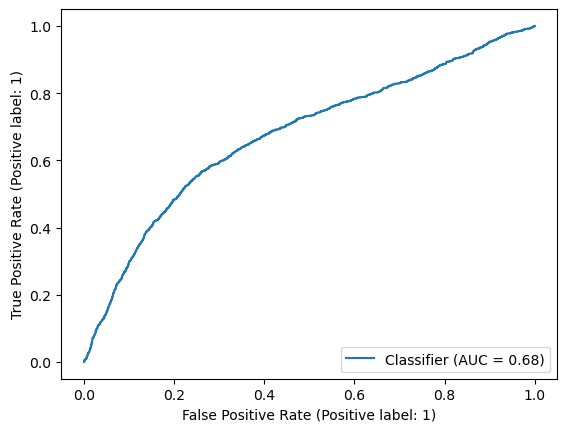

In [10]:
bayes_pred = bayes_results.posterior["is_hit_mean"].values.mean(0).mean(0)
ConfusionMatrixDisplay.from_predictions(y_test, np.round(bayes_pred), display_labels=["Out", "Hit"], colorbar=False, cmap="binary");
RocCurveDisplay.from_predictions(y_test, bayes_pred);
pp.pprint(cm_scores(y_test, np.round(bayes_pred)))


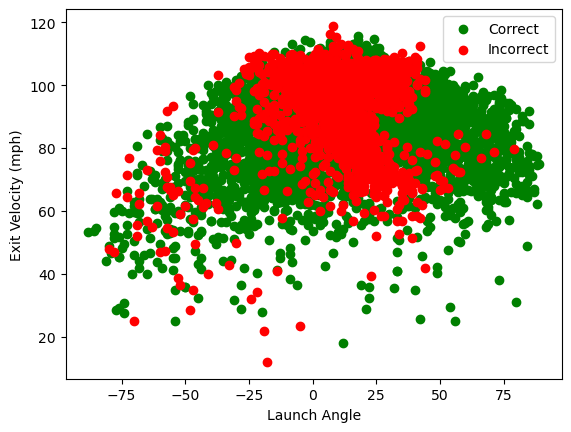

In [11]:
test_with_results = y_test == np.round(bayes_pred)
test_with_results.name="correct"
test_with_results = pd.concat([test_with_results, y_test, X_test], axis="columns")
correct_pred = test_with_results[test_with_results["correct"]]
incorrect_pred = test_with_results[~test_with_results['correct']]
plt.scatter(correct_pred['launch_angle'], correct_pred['launch_speed'], c="green",label="Correct")
plt.scatter(incorrect_pred['launch_angle'], incorrect_pred['launch_speed'], c="red",label="Incorrect")
plt.xlabel("Launch Angle")
plt.ylabel("Exit Velocity (mph)")
plt.legend();


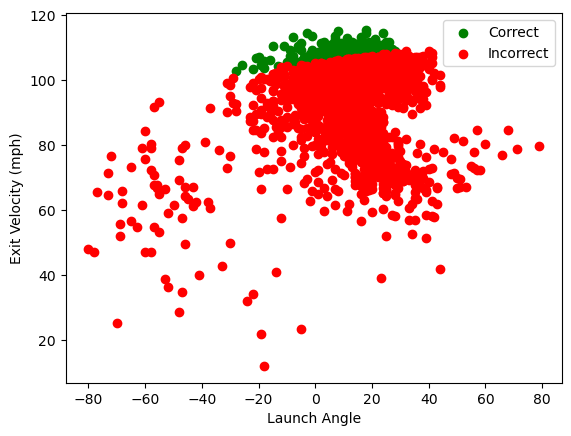

In [12]:
correct_hit_pred = test_with_results[test_with_results["correct"] & test_with_results["is_hit"]]
incorrect_hit_pred = test_with_results[~test_with_results['correct'] & test_with_results["is_hit"]]
plt.scatter(correct_hit_pred['launch_angle'], correct_hit_pred['launch_speed'], c="green",label="Correct")
plt.scatter(incorrect_hit_pred['launch_angle'], incorrect_hit_pred['launch_speed'], c="red",label="Incorrect")
plt.xlabel("Launch Angle")
plt.ylabel("Exit Velocity (mph)")
plt.legend();


## Bayes with Type Level Effects

In [14]:
# Launch Distance Model
# priors2 = {
#     "launch_speed": bmb.Prior("Normal", mu=0, sigma=10),
#     "launch_angle": bmb.Prior("Normal", mu=0, sigma=10),
#     "hit_distance_sc": bmb.Prior("Normal", mu=0, sigma=10),
#     "launch_angle:hit_distance_sc": bmb.Prior("Normal", mu=0, sigma=10),
# }
# formula = "is_hit ~ launch_speed + launch_angle*hit_distance_sc"

priors2 = {
    "(1|bb_type)": bmb.Prior("Normal", mu=0, sigma=10),
    "(launch_speed|bb_type)": bmb.Prior("Normal", mu=0, sigma=10),
}
formula = "is_hit ~ (launch_speed | bb_type)"

bayes_model2 = bmb.Model(formula, data=bayes_data, priors=priors2, family="bernoulli")
model_filepath = os.path.join(current_folder, r"models/bayes_with_bbtype_effects.model")
if os.path.exists(model_filepath):
    bayes_results2 = az.from_netcdf(model_filepath)
else:
    bayes_results2 = bayes_bb_type_model.fit(tune=500, draws=1000,chains=4, 
        cores=cpu_count(), inference_method="nuts_numpyro")
    az.to_netcdf(bayes_bbtype_results, model_filepath)

In [16]:
bayes_model2.predict(bayes_results2, data=X_test, kind="pps")

In [20]:
az.summary(bayes_results2, kind="stats", 
    filter_vars="like", var_names=["Intercept", "bb_type"])

,mean,sd,hdi_3%,hdi_97%
Intercept,-2.704,1.415,-5.245,0.057
1|bb_type_sigma,3.139,1.090,1.453,5.070
launch_speed|bb_type_sigma,0.061,0.029,0.023,0.115
1|bb_type[fly_ball],-5.280,1.461,-8.192,-2.726
1|bb_type[ground_ball],-0.456,1.423,-3.232,2.063
1|bb_type[line_drive],1.055,1.428,-1.703,3.624
1|bb_type[popup],0.394,1.681,-2.790,3.466
launch_speed|bb_type[fly_ball],0.075,0.004,0.066,0.083
launch_speed|bb_type[ground_ball],0.023,0.002,0.019,0.027
launch_speed|bb_type[line_drive],0.023,0.003,0.018,0.029


{ 'Accuracy': 0.7427325581395349,
  'F1 Score': 0.5524023602135432,
  'Sensitivity': 0.48233562315996076,
  'Specificity': 0.8704862782859895}


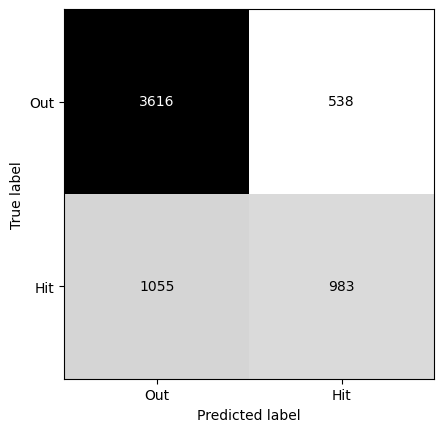

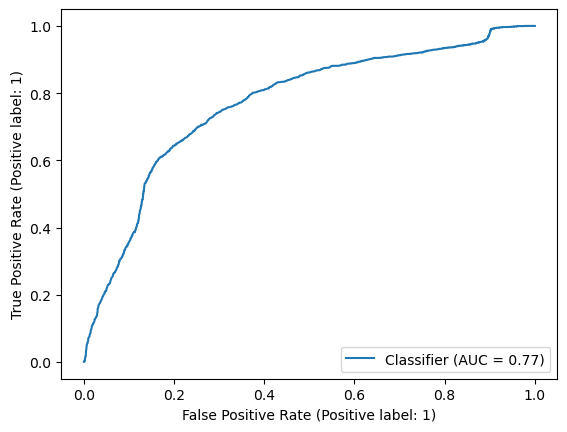

In [21]:
bayes_pred2 = bayes_results2.posterior["is_hit_mean"].values.mean(0).mean(0)
ConfusionMatrixDisplay.from_predictions(y_test, np.round(bayes_pred2), display_labels=["Out", "Hit"], colorbar=False, cmap="binary");
RocCurveDisplay.from_predictions(y_test, bayes_pred2);
pp.pprint(cm_scores(y_test, np.round(bayes_pred2)))
